## Import libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

%matplotlib inline

## Helper functions for Visualization


In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [0]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

## Data Loading and Transformations

In [0]:
# Define a transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

In [0]:
# Load data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Define data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

label: 6


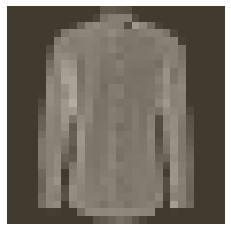

In [6]:
# Example Image
image, label = next(iter(trainloader))
imshow(image[0].view(1, 28, 28))
print('label: {}'.format(label[0].item()))

## Create Model (Without Regularization)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        ''' Creates a Classifier model for Fashion MNIST dataset. '''
        super().__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        #flattened input tensor
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.log_softmax(self.layer4(x), dim=1)
        
        return x

## Training Process

In [0]:
# Define model, cost function and optimizer
model = Classifier()

cost = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [9]:
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    for X, Y in trainloader:
        # train
        optimizer.zero_grad()
        # forward pass
        Y_hat = model.forward(X)  
        # backward pass 
        loss = cost(Y_hat, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        # validate
        test_loss = 0
        test_acc = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for X, Y in testloader:
                Y_hat = model.forward(X)
                test_loss += cost(Y_hat, Y)
                
                Y_hat = torch.exp(Y_hat)
                top_p, top_class = Y_hat.topk(1, dim=1)
                equals = top_class == Y.view(*top_class.shape)
                test_acc += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.2f}%".format((test_acc/len(testloader))* 100))

Epoch: 1/30..  Training Loss: 0.511..  Test Loss: 0.435..  Test Accuracy: 83.95%
Epoch: 2/30..  Training Loss: 0.378..  Test Loss: 0.392..  Test Accuracy: 85.91%
Epoch: 3/30..  Training Loss: 0.344..  Test Loss: 0.372..  Test Accuracy: 86.46%
Epoch: 4/30..  Training Loss: 0.321..  Test Loss: 0.372..  Test Accuracy: 86.81%
Epoch: 5/30..  Training Loss: 0.302..  Test Loss: 0.355..  Test Accuracy: 87.36%
Epoch: 6/30..  Training Loss: 0.287..  Test Loss: 0.350..  Test Accuracy: 87.80%
Epoch: 7/30..  Training Loss: 0.274..  Test Loss: 0.384..  Test Accuracy: 86.38%
Epoch: 8/30..  Training Loss: 0.266..  Test Loss: 0.362..  Test Accuracy: 87.48%
Epoch: 9/30..  Training Loss: 0.254..  Test Loss: 0.337..  Test Accuracy: 88.31%
Epoch: 10/30..  Training Loss: 0.247..  Test Loss: 0.341..  Test Accuracy: 88.46%
Epoch: 11/30..  Training Loss: 0.239..  Test Loss: 0.365..  Test Accuracy: 87.40%
Epoch: 12/30..  Training Loss: 0.232..  Test Loss: 0.354..  Test Accuracy: 88.28%
Epoch: 13/30..  Training 

## Visualization of Losses

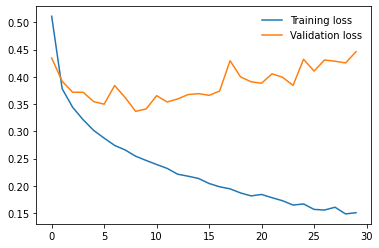

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Predictions

In [0]:
def predict():
    '''Chooses a random Image from Testset and classifies it'''
    X, Y = next(iter(testloader))
    x = X[0]

    with torch.no_grad():
        y_hat = model.forward(x)
    
    y_hat = torch.exp(y_hat)
    view_classify(x.view(1, 28, 28), y_hat)

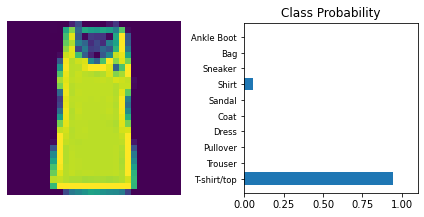

In [12]:
predict()

## Create Model (With Dropout Regularization)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        ''' Creates a Classifier model for Fashion MNIST dataset. '''
        super().__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #flattened input tensor
        x = x.view(x.shape[0], -1)
        
        # with dropout
        x = self.dropout(F.relu(self.layer1(x)))
        x = self.dropout(F.relu(self.layer2(x)))
        x = self.dropout(F.relu(self.layer3(x)))

        # output --> no dropout
        x = F.log_softmax(self.layer4(x), dim=1)
        
        return x

## Training Process

In [0]:
# Define model, cost function and optimizer
model = Classifier()

cost = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [15]:
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    for X, Y in trainloader:
        # train
        optimizer.zero_grad()
        # forward pass
        Y_hat = model.forward(X)  
        # backward pass 
        loss = cost(Y_hat, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        # validate
        test_loss = 0
        test_acc = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # Turn off dropout
            model.eval()
            for X, Y in testloader:
                Y_hat = model.forward(X)
                test_loss += cost(Y_hat, Y)
                
                Y_hat = torch.exp(Y_hat)
                top_p, top_class = Y_hat.topk(1, dim=1)
                equals = top_class == Y.view(*top_class.shape)
                test_acc += torch.mean(equals.type(torch.FloatTensor))

        # Turn on dropuout
        model.train()
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.2f}%".format((test_acc/len(testloader))* 100))

Epoch: 1/30..  Training Loss: 0.606..  Test Loss: 0.456..  Test Accuracy: 83.68%
Epoch: 2/30..  Training Loss: 0.460..  Test Loss: 0.410..  Test Accuracy: 84.98%
Epoch: 3/30..  Training Loss: 0.421..  Test Loss: 0.399..  Test Accuracy: 85.78%
Epoch: 4/30..  Training Loss: 0.398..  Test Loss: 0.387..  Test Accuracy: 86.25%
Epoch: 5/30..  Training Loss: 0.387..  Test Loss: 0.375..  Test Accuracy: 86.62%
Epoch: 6/30..  Training Loss: 0.373..  Test Loss: 0.382..  Test Accuracy: 86.43%
Epoch: 7/30..  Training Loss: 0.368..  Test Loss: 0.371..  Test Accuracy: 87.13%
Epoch: 8/30..  Training Loss: 0.357..  Test Loss: 0.374..  Test Accuracy: 87.05%
Epoch: 9/30..  Training Loss: 0.347..  Test Loss: 0.372..  Test Accuracy: 87.18%
Epoch: 10/30..  Training Loss: 0.347..  Test Loss: 0.370..  Test Accuracy: 86.98%
Epoch: 11/30..  Training Loss: 0.340..  Test Loss: 0.367..  Test Accuracy: 87.42%
Epoch: 12/30..  Training Loss: 0.334..  Test Loss: 0.377..  Test Accuracy: 86.79%
Epoch: 13/30..  Training 

## Visualization of Losses

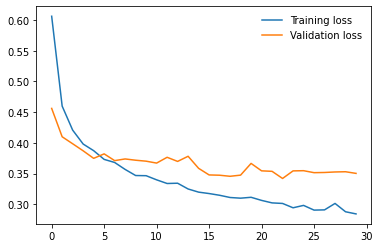

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Predictions

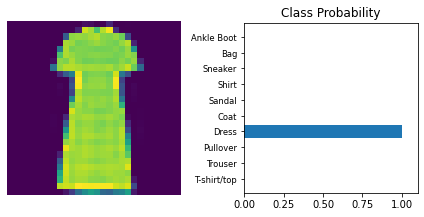

In [17]:
predict()